# Downloading the EMNIST dataset using the Kaggle API

In [2]:
import os
import subprocess

files = ['emnist-balanced-test.csv', 'emnist-balanced-train.csv']
flag = True

for file in files:
    file_path = os.path.join('./', file)
    if os.path.exists(file_path):
        print(f"{file} exists.")
    else:
        print(f"{file} does not exist.")
        flag = False

if not flag:
    print("Downloading required files...")
    command = "kaggle datasets download -d crawford/emnist"
    process = subprocess.run(command, shell=True, check=True, capture_output=True)
    print(f"Process output: {process.stdout}")

emnist-balanced-test.csv exists.
emnist-balanced-train.csv exists.


In [2]:
import zipfile

dataset = 'emnist.zip'
files = ['emnist-balanced-test.csv', 'emnist-balanced-train.csv']

if not flag:
    with zipfile.ZipFile(dataset, 'r') as z:
        for file_info in z.infolist():
            if file_info.filename in files:
                z.extract(file_info)

    os.remove(dataset)

# Install necessary packages

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import string
import logging
import time
import warnings

warnings.filterwarnings('always')
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ExponentialLR
from torchvision.transforms import v2

import cupy as cp
use_cupy = torch.cuda.is_available()

from skorch.classifier import NeuralNetClassifier
from skorch.callbacks import Callback
from skorch.callbacks import LRScheduler

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Select device (CPU/GPU)

In [7]:
# choose the device
def chooseDevice(model = None):
  device = "cuda" if torch.cuda.is_available() else "cpu"
  print(f"Using {device} device")
  
  # Additional code if multiple GPUs available
  if device=="cuda" and torch.cuda.device_count() >1:
    print(f"Multiple GPUs available ({torch.cuda.device_count()})... Using data parallelization for {model}")
    model = nn.DataParallel(model)
    
  return device


device = chooseDevice()

Using cuda device


In [5]:
def array_module(array):
    """
    Returns the appropriate library for operations based on the input type (NumPy or CuPy).
    """
    return cp if use_cupy and isinstance(array, cp.ndarray) else np

# Create custom Dataset for EMNIST

### Custom EMNIST Dataset Class

In [13]:
class EMNISTDataset(Dataset):
  """
  A custom dataset class based on torch.utils.data.Dataset for handling EMNIST data.

  This dataset class is designed to load and transform data from a CSV file containing EMNIST images. 
  It supports transformation and formatting of data suitable for use with PyTorch models.

  Parameters:
      csv_file (str)
      transform (callable, optional): optional transform to be applied on a sample.

  Attributes:
      data_frame (pandas.DataFrame)
      transform (callable)
  """
  def __init__(self, csv_file, transform=None):
    self.data_frame = pd.read_csv(csv_file)
    self.transform = transform

  def __len__(self):
    """
    Returns the total number of samples in the dataset.
    """
    return len(self.data_frame)

  def __getitem__(self, idx):
    """
    Fetches an images and its label at a given index in the dataset.

    Parameters:
        idx (int)

    Returns:
        tuple: (image, label) where image is transformed to tensor.
    """
    if torch.is_tensor(idx):
        idx = idx.tolist()

    img = self.data_frame.iloc[idx, 1:].values.astype(np.uint8).reshape(28, 28, 1)
    label = int(self.data_frame.iloc[idx, 0])

    if self.transform:
        img = self.transform(img)
        
    if isinstance(img, torch.Tensor): # if img already a tensor
      img = img.clone().detach()  # then copy it
    else: 
      xp = array_module(img) # else get array moudule (NumPy / CuPy) based on device
      img = xp.asarray(img)
    
      img = torch.tensor(img, dtype=torch.float32) # and convert to tensor

              
    return img, label
  
  # get_X_y method returns the input vector X (images) and the output vector y (label)
  def get_X_y(self):
    """
    Fetches all images and labels from the dataset.

    Returns:
        tuple: (X, y) where X is a tensor of all images and y is a tensor of all labels.
    """
    X = []
    y = []
    
    for idx in range(len(self.data_frame)): 
      img, label = self[idx] # use the __getitem__ method to get image and label based on index
      X.append(img)
      y.append(label)
    
    X = torch.stack(X) # stack image tensors into one tensor
    y = torch.tensor(y, dtype=torch.long) # convert output to tensor
    
    return X, y

### Transformations

In [14]:
transform_train = v2.Compose([
    v2.ToPILImage(), # tranform to PIL (Python Image Library) image
    v2.RandomRotation(degrees=(0,45)), # Rotate -90 degrees
    v2.RandomAffine(degrees=0, translate=(0.05, 0.05), 
                             scale=(0.9, 1.1), shear=10),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True), # Transform to tensor
    v2.Normalize((0.5,), (0.5,)), # Normalise with mean=.5 and std=.5
    ])

transform_test = v2.Compose([
    v2.ToPILImage(), # tranform to PIL (Python Image Library) image
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True), # Transform to tensor (!!! v2.ToTorch() to be removed in future torchvision releases)
    v2.Normalize((0.5,), (0.5,)),
    ])

### Create training and test sets

In [15]:
train_dataset = EMNISTDataset(csv_file='emnist-balanced-train.csv', transform=transform_train)
test_dataset = EMNISTDataset(csv_file='emnist-balanced-test.csv', transform=transform_test)

print(f"Training dataset length = {train_dataset.__len__()} samples")
print(f"Test dataset length = {test_dataset.__len__()} samples")

Training dataset length = 112799 samples
Test dataset length = 18799 samples


# Visualitions for EMNIST Dataset

### Create label map

In [24]:
digits = [str(i) for i in range(10)]
letters = list(string.ascii_uppercase) + list(string.ascii_lowercase)

for letter in ['c', 'i', 'j', 'k', 'l', 'm', 'o', 'p', 's', 'u', 'v', 'w', 'x', 'y','z']:
    letters.remove(letter)
    
label_map = digits + letters

### Visualisation function

In [10]:
def visualise_dataset(dataset, set, num_images=25):
    """
    Visualizes a random subset of images from the specified dataset.

    Parameters:
        dataset (Dataset)
        set (str): name for the dataset to be displayed as part of the title.
        num_images (int, optional): number of images to display, default value 25.
    """
    # Create a grid layout for the images
    rows = int(np.ceil(np.sqrt(num_images)))
    cols = int(np.ceil(num_images / rows))
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    
    fig.suptitle(f"Subset of {set} Dataset\n", fontsize=16)

    # Flatten the axes if necessary
    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = [axes]

    indices = np.random.choice(len(dataset), num_images, replace=False) # get random indices

    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        ax = axes[i]
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(f"Truth Label: {label_map[label]}")
        ax.axis('off')

    # Hide any remaining empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()


### Visualising random images from training and test sets

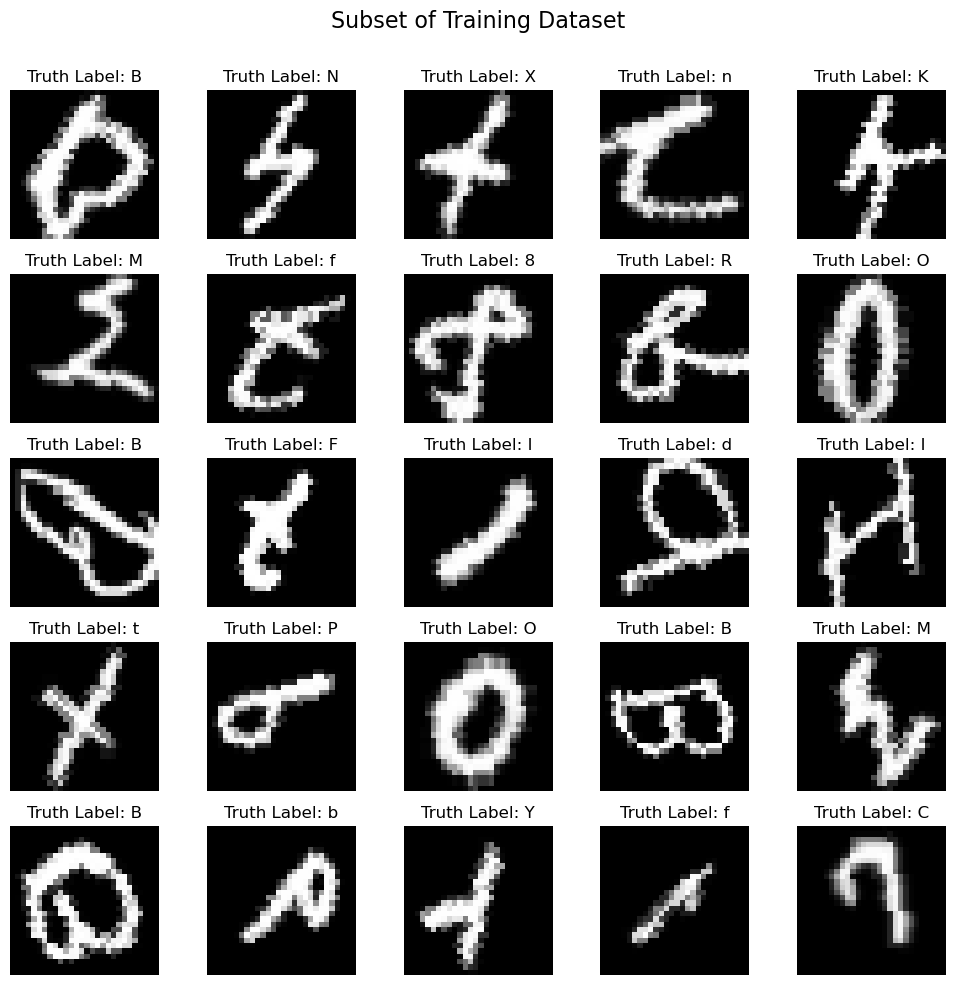

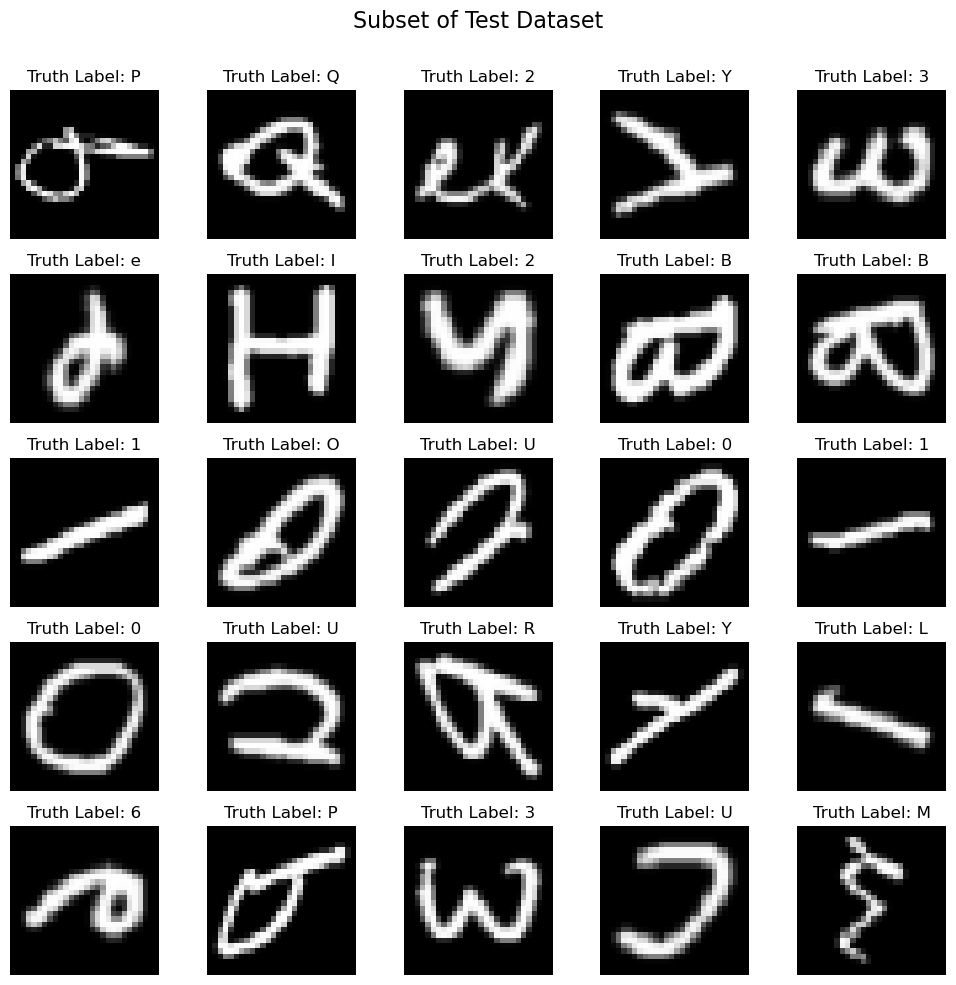

In [11]:
visualise_dataset(train_dataset, 'Training')
visualise_dataset(test_dataset, 'Test')

# Utility functions

### MLP and CNN Constructor functions

This function has been implemented due to the use of `skorch.classifier.NeuralNetClassifier` within the hyperparameter optimisation function, which requires dynamic re-instiation of the model during GridSearch.

In [8]:
def model_constructor_factory(model_class, **fixed_args):
    """
    Factory function to create instances of a specified PyTorch model class with fixed arguments.
    
    This factory function simplifies the instantiation of `torch.nn.Module` subclasses by allowing
    specifying some of the initialization arguments beforehand. The returned constructor will only 
    require the remaining arguments that weren't specified to create an instance of the model.
    
    Parameters:
        model_class (torch.nn.Module)
         **fixed_args (dict)
         
    Returns:
        function
    """
    def model_constructor(**kwargs):
        return model_class(**{**fixed_args, **kwargs})
    return model_constructor

### Hyperparameter Optimisation function

In [13]:
def prepare_data_for_model(X, model_type):
    """
    Prepares input data for different types of neural network models by reshaping it
    according to the model's requirements.

    Parameters:
        X (torch.Tensor)
        model_type (str): type of depp learning model

    Returns:
        torch.Tensor: A tensor with the data reshaped appropriate to the type of model. For CNN,
                    the data will be reshaped to [batch_size, 1, 28, 28]. For MLP, the data
                    will be reshaped to [batch_size, features].

    Raises:
        ValueError
    """
    if model_type == 'CNN':
        # Reshape for CNN: assume input X is in shape [batch_size, 784]
        return X.view(-1, 1, 28, 28)  # Reshape to [batch_size, channels, height, width]
    elif model_type == 'MLP':
        # For MLP, ensure data is flattened
        return X.view(X.size(0), -1)  # Flatten the data
    else:
        raise ValueError("Unsupported model type")


In [14]:
def hyperparameter_optimisation(model_constructor, name, X, y, device='cpu'):
    class ParameterLogger(Callback):
        def on_train_begin(self, net, X, y, **kwargs):
            logging.info(f"Starting training with parameters: {net.get_params()}")
            
    if torch.is_tensor(X): # if X tensor, move it to CPU, data needs to be on the CPU and in a NumPy-compatible format
        X = prepare_data_for_model(X, name)  # Adjust shape based on model type
        X = X.cpu().numpy()
    if torch.is_tensor(y): # if y tensor, move it to CPU
        y = y.cpu().numpy()

    # skorch wrapper for model
    model = NeuralNetClassifier(
        module=model_constructor,
        criterion = nn.CrossEntropyLoss(),
        optimizer=optim.SGD,
        optimizer__lr=0.01,
        callbacks=[('lr_scheduler', LRScheduler(policy=ExponentialLR, gamma=0.1))], # callback Logger and scheduler callback
        device=device,
        verbose=True
    )
    
    param_grid = {
        'module__use_dropout': [True, False], 
        'module__use_batchnorm': [True, False],
        'optimizer': [optim.Adam, optim.SGD, optim.RMSprop],
        'optimizer__lr': [.001, .01, .1],
        'optimizer__weight_decay': [.001, .01, .1],
        'callbacks__lr_scheduler__gamma': [0.1, 0.5],
        'batch_size': [64],
        'max_epochs': [10]
    }

    if name == 'MLP':
        param_grid['module__activation'] = [F.relu, F.leaky_relu, F.elu]
        param_grid['module__input_size'] = [784]
        param_grid['module__output_layer_sizes'] = [[256, 128, 47]]
    if name == 'CNN':
        param_grid['module__activation'] = [nn.ReLU, nn.LeakyReLU, nn.ELU]
        param_grid['module__num_classes'] = [47]
        param_grid['module__channels'] = [[32, 64]]
        param_grid['module__kernel_sizes'] = [[3, 3]]
        param_grid['module__dropout_rate'] = [0.5]
    
    xp = array_module(X) # get array module (NumPy / CuPy) based on device
    X = xp.asarray(X)
    y = xp.asarray(y)

    grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                        scoring='accuracy', n_jobs=-1, verbose=3)

    start_time = time.perf_counter()
    grid_result = grid.fit(X, y)
    stop_time = time.perf_counter()
    
    print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print(f"{mean:.3f} ({stdev:.3f}) with: {param}")
    
    print(f"Execution time for {name} hyperparameter tuning: {(stop_time-start_time)/60:.2f} minutes.")
        
    return grid_result

### Model Training function

In [9]:
def train_model(model, name, train_loader, device, hyp_opt_params=None, criterion = nn.CrossEntropyLoss()):
    """
    Trains a given model using the provided training loader and hyperparameter settings.

    Parameters:
        model (torch.nn.Module)
        name (str): name of deep learning model
        train_loader (torch.utils.data.DataLoader)
        hyp_opt_params (object)
        device (torch.device)
        criterion (torch.nn.modules.loss._Loss)

    Returns:
        tuple: A tuple containing the trained model, list of training losses, and list of training accuracies.
    """
    model.train()
    train_losses = []
    train_accuracies = []
    
    if hyp_opt_params:
        optimizer = hyp_opt_params.best_params_['optimizer'](model.parameters(), lr=hyp_opt_params.best_params_['optimizer__lr'],
                                                    weight_decay=hyp_opt_params.best_params_['optimizer__weight_decay']) # get best optmiser for model
        scheduler = ExponentialLR(optimizer=optimizer, gamma=hyp_opt_params.best_params_['callbacks__lr_scheduler__gamma'])
    else:
        optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01)
        scheduler = ExponentialLR(optimizer=optimizer, gamma=0.1)
        
    criterion = criterion # set loss criterion
    
    
    start_time = time.perf_counter()
    
    for epoch in range(hyp_opt_params.best_params_['max_epochs'] if hyp_opt_params else 10):
        epoch_loss = 0
        correct = 0 # sum of correct predictions
        
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            if name == "MLP":    
                data = data.view(data.shape[0], -1)  # Flatten the data
            optimizer.zero_grad()
            output = model(data)
            
            loss = criterion(output, target)
            loss.backward()
            
            optimizer.step()
            
            epoch_loss += loss.item()*data.size(0)
            
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == target).sum().item()
            
        scheduler.step()

        epoch_loss /= len(train_loader.dataset)
        epoch_accuracy = correct / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        
        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.3f}, Accuracy: {epoch_accuracy*100:.3f}%")
    
    stop_time = time.perf_counter()
    
    print(f"Training time for {name} = {(stop_time-start_time)/60:.2f} minutes.")

    return model, train_losses, train_accuracies

### Compute Performance Metrics

In [10]:
def compute_metrics(predictions, labels, name):
    """
    Computes and prints the classification metrics for given predictions and true labels.

    Parameters:
        predictions (array-like)
        labels (array-like)
        name (str): name of deep learning model
    """
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    f1 = f1_score(labels, predictions, average='weighted')
    
    print(f"Accuracy for {name} = {accuracy*100:.3f}%")
    print(f"Precision for {name} = {precision:.3f}")
    print(f"Recall for {name} = {recall:.3f}")
    print(f"F1-score for {name} = {f1:.3f}")
    # return accuracy, precision, recall, f1

### Model Evaluation function

In [ ]:
def evaluate(model, name, test_loader, device, criterion = nn.CrossEntropyLoss()):
    """
    Evaluates the model on a test dataset and prints the test loss.

    Parameters:
        model (torch.nn.Module)
        name (str): name of deep learning model
        test_loader (torch.utils.data.DataLoader)
        device (torch.device)
        criterion (torch.nn.modules.loss._Loss)

    Returns:
        tuple: Returns the average test loss, a list of predictions, and a list of actual labels from the test dataset.
    """
    model.eval()
    test_loss = 0
    predictions = []
    labels = []
    criterion = criterion
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            if name == 'CNN':
                data = data.view(-1, 1, 28, 28)  # Reshape data for CNN
            else:
                data = data.view(data.shape[0], -1)  # Flatten the data
            outputs = model(data)
            
            loss = criterion(outputs, target)
            test_loss += loss.item()*data.size(0)
            
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.cpu().tolist())
            labels.extend(target.cpu().tolist())


    test_loss /= len(test_loader.dataset)
    # Compute final results

    print(f"Test Loss for {name}: {test_loss:.2f}")
    
    compute_metrics(predictions=predictions, labels=labels, name=name)
    
    return test_loss, predictions, labels

### Plot Epoch Loss and Accuracy

In [12]:
def plot_metrics(train_losses, accuracies):
    """
    Plots training loss and accuracy over epochs.

    Parameters:
        train_losses (list of float)
        accuracies (list of float)
    """
    epochs = range(1, len(train_losses) + 1)
    
    fig, ax1 = plt.subplots(figsize=(10, 5))
    
    # Plot losses
    color = 'tab:red'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color=color)
    ln1 = ax1.plot(epochs, train_losses, label='Training Loss', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    # Creating a second y-axis for accuracies
    ax2 = ax1.twinx()  # second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('Accuracy', color=color)
    ln2 = ax2.plot(epochs, accuracies, label='Validation Accuracy', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    
    handles, labels = [], []
    handles.extend(ln1 + ln2)
    labels.extend([l.get_label() for l in ln1+ln2])
    plt.legend(handles, labels, loc='upper right')

    plt.title('Training Loss and Accuracy')
    plt.show()

### Plot Predictions

In [13]:
def visualise_predictions(dataset_loader, predictions):
    """
    Displays images from a dataset along with their predicted and actual labels.

    Parameters:
        dataset_loader (torch.utils.data.DataLoader)
        predictions (list of int)
    """
    images, true_labels = next(iter(dataset_loader))
    
    _, axs = plt.subplots(1, 6, figsize=(10, 5))
    for i in range(6):
        image = images[i].squeeze()
        axs[i].imshow(image, cmap='gray')  # Adjust if your images have a different format
        axs[i].set_title(f"Prediction: {label_map[predictions[i]]}\nTruth: {label_map[true_labels[i]]}")
        axs[i].axis('off')

### Plot Confusion Matrix

In [14]:
def plot_confusion_matrix(labels, predictions):
    """
    Plots a confusion matrix for given true labels and predictions.

    Parameters:
        labels (list of int)
        predictions (list of int)
    """
    conf_matrix = confusion_matrix(labels, predictions)
    
    # Plot confusion matrix
    plt.figure(figsize=(20, 20))
    sns.heatmap(conf_matrix, cmap='Blues', cbar=True, xticklabels=label_map, yticklabels=label_map)
    plt.xlabel('Predicted Labels', fontsize=18)
    plt.ylabel('True Labels', fontsize=18)
    plt.title('Confusion Matrix', fontsize=20)
    plt.show()

### Get training images and labels (used in all models)

In [16]:
X_train, y_train = train_dataset.get_X_y() # get all images and labels
X_train = X_train.view(X_train.size(0), -1).float().to(device) # Flatten image and convert to float
y_train = y_train.long().to(device) # Convert to long

print("Data shape:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

Data shape:
X_train shape: torch.Size([112799, 784])
y_train shape: torch.Size([112799])


# Creation, fine-tuning, training and evaluation of Multilayer Perceptron (MLP) model

### Define MLP model

In [5]:
# Custom Multilayer Perceptron (MLP) class to allow easily changing parameters
class MLP(nn.Module):
  """
  A custom Multilayer Perceptron (MLP) class that can be easily adjusted to change its architecture.

  Parameters:
      input_size (int): size of the input features.
      output_layer_sizes (list of int): a list of integers where each integer represents the 
          number of neurons in a layer. The number of items in the list determines the number of layers.
      activation (callable, optional): activation function to use after each layer except the last one, default activation
          is torch.nn.functional.relu.
      use_dropout (bool, optional): if True, applies dropout to each layer except the last one, default value False.
      use_batchnorm (bool, optional): if True, applies batch normalization to each layer except the last one, 
          default value False.

  Attributes:
      layers (torch.nn.ModuleList): list of the fully connected layers.
      activation_func (callable): activation function used in the network.
      dropout (torch.nn.Dropout): dropout module applied to each layer if enabled.
      batch_norms (torch.nn.ModuleList): list of batch normalization modules applied to each layer if enabled.
  """
  def __init__(self, input_size, output_layer_sizes, activation=F.relu, use_dropout=False, use_batchnorm=False):
    super().__init__()
    self.layers = nn.ModuleList() # list to hold layer submodules
    self.activation_func = activation # activation function variable
    self.dropout = nn.Dropout(p=0.5) if use_dropout else nn.Dropout(p=0) # dropout rate
    self.use_batch_norm = use_batchnorm # boolean variable for batch normalisation
    self.batch_norms = nn.ModuleList() # list to hold batch normalisation submodules

    # Create MLP layers
    for i, layer_size in enumerate(output_layer_sizes):
      if i == 0:
          self.layers.append(nn.Linear(in_features=input_size, out_features=layer_size)) # first layer takes all input features = input_size
      else:
          self.layers.append(nn.Linear(in_features=output_layer_sizes[i-1], out_features=layer_size))
          
      if use_batchnorm and i < len(output_layer_sizes) - 1:  # Batch-norm except last layer
          self.batch_norms.append(nn.BatchNorm1d(layer_size))

  def forward(self, x):
    """
    Defines the forward pass of the MLP.

    Parameters:
        x (torch.Tensor)

    Returns:
        torch.Tensor
    """
    for i, layer in enumerate(self.layers):
      x = layer(x) # pass input in layer
      if i < len(self.layers) - 1:  # If last layer
        # if self.use_batch_norm:
        x = self.batch_norms[i](x) if self.use_batch_norm else x
        x = self.activation_func(x)
        x = self.dropout(x)
    return x

In [8]:
# MLP model with 4 fully-connected layers, RELU activation functions, no dropout
mlp = MLP(input_size=784, output_layer_sizes=[512, 256, 128, 47]).to(device) 

print(f"Multilayer Perceptron (MLP) model Architecture:\n\n{mlp}")

Multilayer Perceptron (MLP) model Architecture:

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=47, bias=True)
  )
  (dropout): Dropout(p=0, inplace=False)
  (batch_norms): ModuleList()
)


In [22]:
torch.onnx.export(mlp, X_train[:1], 'mlp.onnx', input_names=["features"], output_names=["outputs"])

### Training Baseline Model

Epoch 1, Loss: 3.852, Accuracy: 2.176%
Epoch 2, Loss: 3.851, Accuracy: 2.160%
Epoch 3, Loss: 3.850, Accuracy: 2.098%
Epoch 4, Loss: 3.850, Accuracy: 2.128%
Epoch 5, Loss: 3.850, Accuracy: 2.128%
Epoch 6, Loss: 3.850, Accuracy: 2.128%
Epoch 7, Loss: 3.850, Accuracy: 2.128%
Epoch 8, Loss: 3.850, Accuracy: 2.128%
Epoch 9, Loss: 3.850, Accuracy: 2.128%
Epoch 10, Loss: 3.850, Accuracy: 2.128%
Training time for MLP = 10.48 minutes.


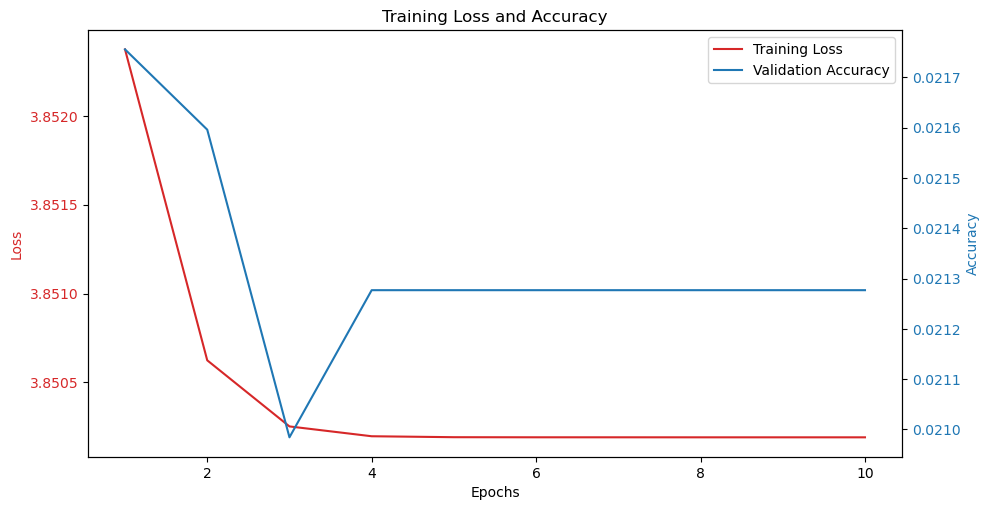

In [24]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) # define data loader, shuffle=True to randomise image order

trained_mlp, train_losses, train_accuracies = train_model(model=mlp, name='MLP', train_loader=train_loader, device=device) # train model

plot_metrics(train_losses=train_losses, accuracies=train_accuracies)

### Hyperparameter Tuning

In [25]:
initial_params = {
    'input_size': 784,
    'output_layer_sizes': [256, 128, 47],
    'activation': F.relu,
    'use_dropout': False,
    'use_batchnorm': False
}

# Model creation for hyperparameter tuning with specified architecture
mlp_constructor = model_constructor_factory(model_class=MLP, **initial_params)

hyp_optimiser = hyperparameter_optimisation(model_constructor=mlp_constructor, name = 'MLP', X=X_train, y=y_train, device=device)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        1.5580       0.5812        1.3883  0.0100  4.7281
      2        1.1178       0.6672        1.0604  0.0050  4.7288
      3        0.9238       0.7164        0.9128  0.0025  4.7790
      4        0.7888       0.7453        0.8047  0.0013  4.7833
      5        0.6913       0.7658        0.7362  0.0006  4.8122
      6        0.6249       0.7770        0.7034  0.0003  4.7028
      7        0.5828       0.7824        0.6886  0.0002  4.7695
      8        0.5575       0.7833        0.6818  0.0001  4.6975
      9        0.5431       0.7832        0.6792  0.0000  4.7029
     10        0.5351       0.7840        0.6783  0.0000  4.7681
Best: 0.7785529733065604 using {'batch_size': 64, 'callbacks__lr_scheduler__gamma': 0.5, 'max_epochs': 10, 'module__activation': <function relu at 0x000001E

### Train Optimised MLP model

Epoch 1, Loss: 1.476, Accuracy: 55.569%
Epoch 2, Loss: 1.113, Accuracy: 65.282%
Epoch 3, Loss: 0.934, Accuracy: 70.663%
Epoch 4, Loss: 0.829, Accuracy: 73.682%
Epoch 5, Loss: 0.764, Accuracy: 75.806%
Epoch 6, Loss: 0.726, Accuracy: 76.852%
Epoch 7, Loss: 0.702, Accuracy: 77.741%
Epoch 8, Loss: 0.688, Accuracy: 78.057%
Epoch 9, Loss: 0.682, Accuracy: 78.153%
Epoch 10, Loss: 0.677, Accuracy: 78.466%
Training time for MLP = 10.05 minutes.


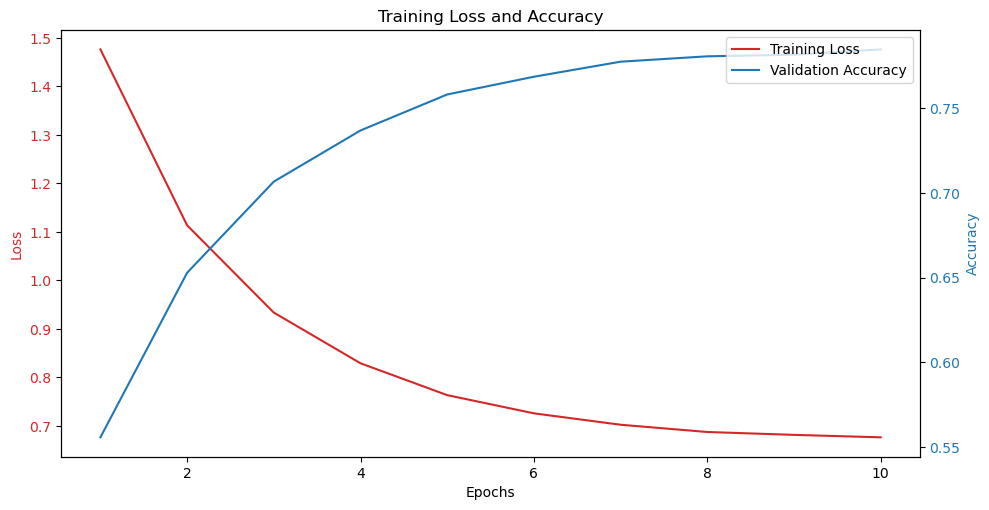

In [30]:
# Define optimised MLP model
mlp = MLP(
    input_size=784, 
    output_layer_sizes=[256, 128, 47],
    activation=hyp_optimiser.best_params_['module__activation'],
    use_dropout=hyp_optimiser.best_params_['module__use_dropout'],
    use_batchnorm=hyp_optimiser.best_params_['module__use_batchnorm']
).to(device)

train_loader = DataLoader(train_dataset, batch_size=hyp_optimiser.best_params_['batch_size'], shuffle=True) # define data loader, shuffle=True to randomise image order

trained_mlp, train_losses, train_accuracies = train_model(model=mlp, name='MLP', train_loader=train_loader, hyp_opt_params=hyp_optimiser, device=device) # train model

plot_metrics(train_losses=train_losses, accuracies=train_accuracies)

### Evaluate MLP model

Test Loss for MLP: 0.67%
Accuracy for MLP = 79.143%
Precision for MLP = 0.794
Recall for MLP = 0.791
F1-score for MLP = 0.789


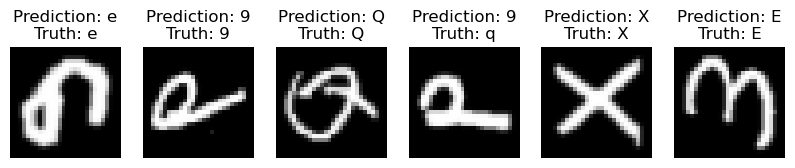

In [31]:
test_loader = DataLoader(test_dataset, batch_size=hyp_optimiser.best_params_['batch_size'], shuffle=False)

# !!! There was a typo within the evaluate() function, test loss is not in percentage, and can't run the code again since kernel
#     timed out and it would take hours to run the hyperparameter optimiser again
# !!!
_, predictions, labels = evaluate(model=mlp, name='MLP', test_loader=test_loader, device=device)

visualise_predictions(test_loader, predictions)

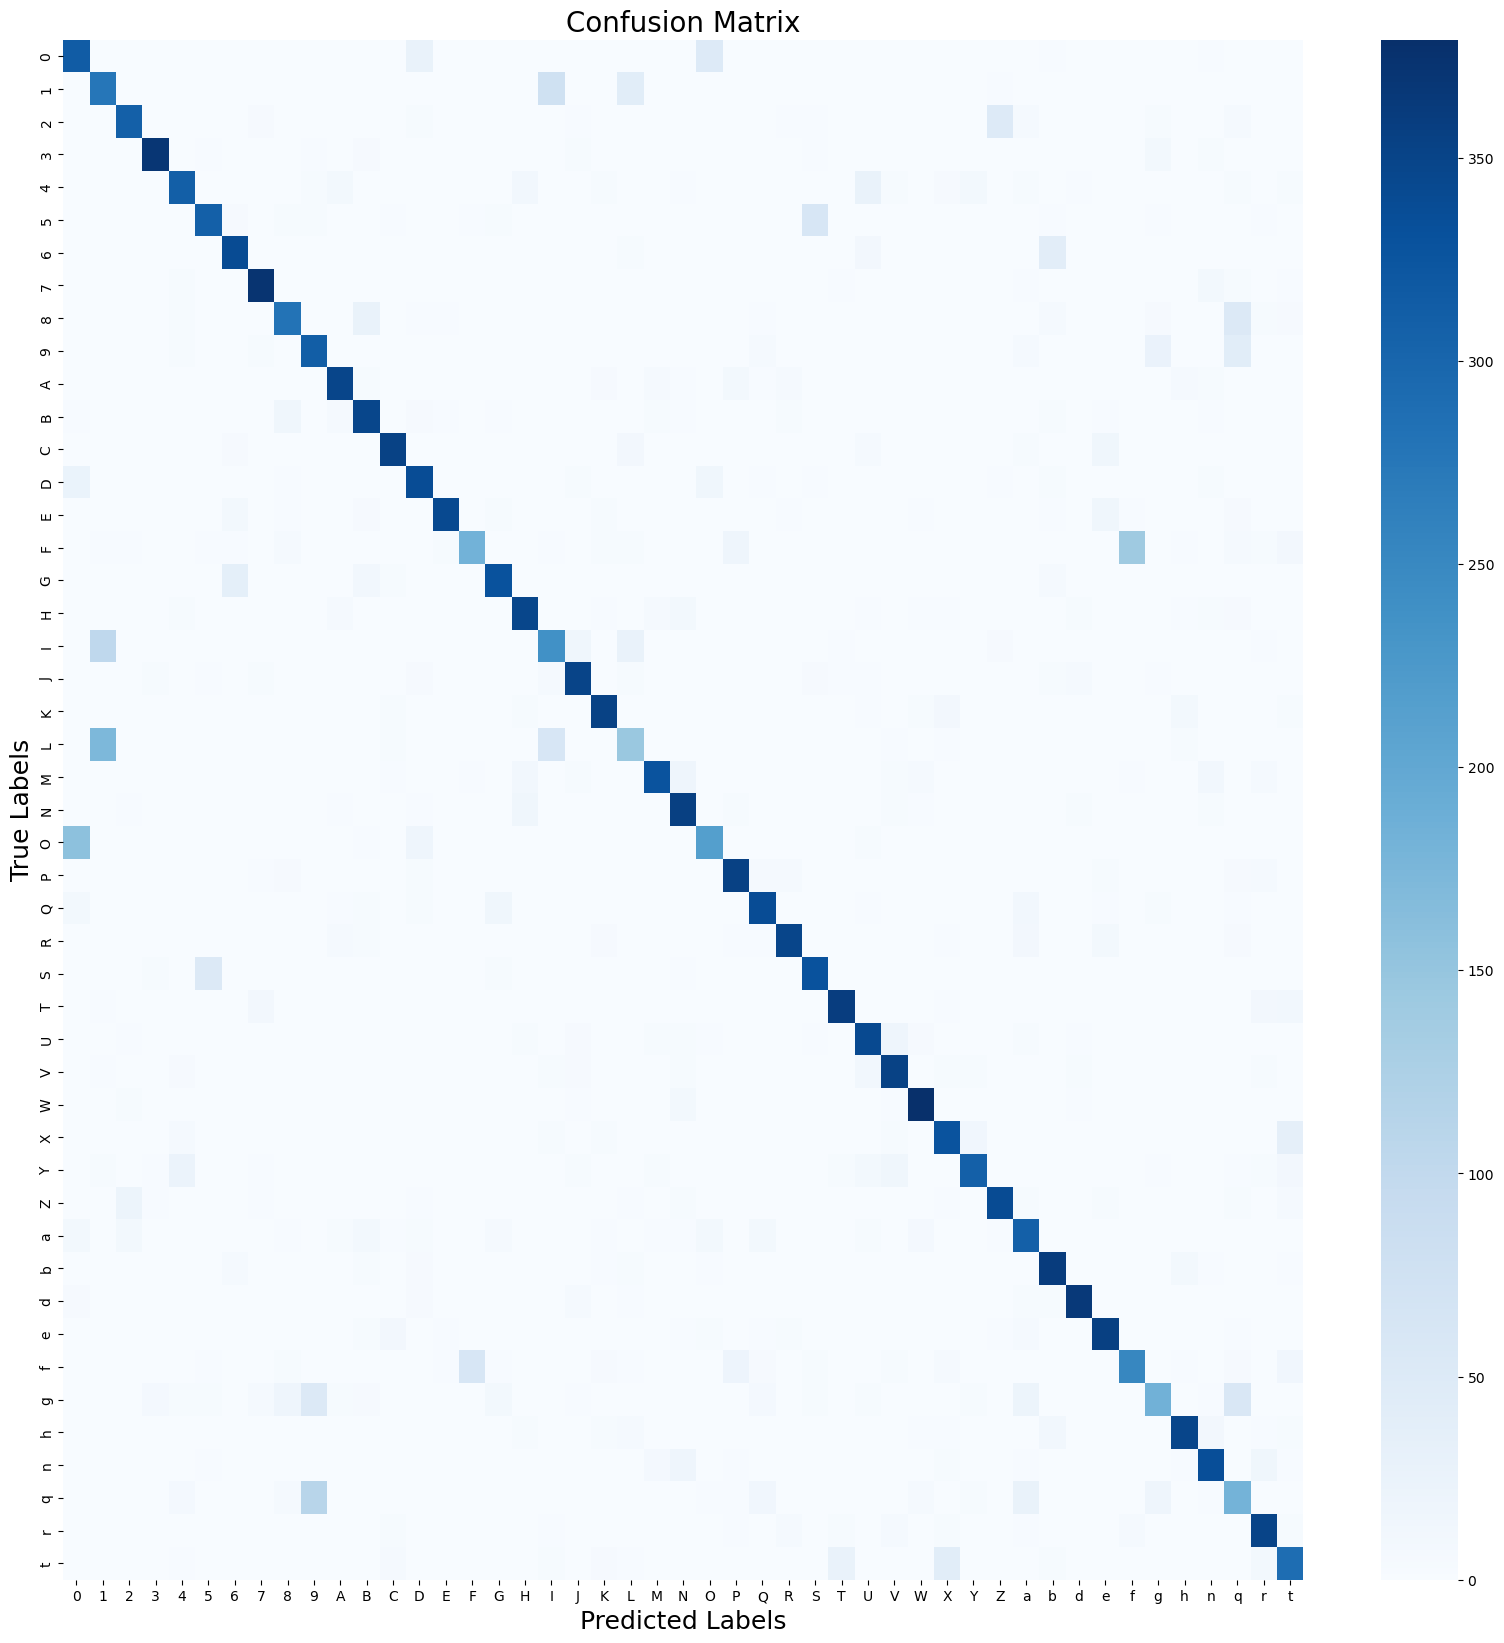

In [32]:
plot_confusion_matrix(labels=labels, predictions=predictions)

# Creation, fine-tuning, training and evaluation of Convolutional Neural Network (CNN)

### Define CNN model

In [9]:
class FlexibleCNN(nn.Module):
    """
    A custom Convolutional Neural Network (CNN) class that can be easily adjusted to change its architecture.

    Parameters:
        num_classes (int): number of output classes.
        channels (list of int): number of output channels for each convolutional layer, default list [32, 64].
        kernel_sizes (list of int): size of the convolution kernels for each layer, default list [3, 3].
        activation (callable): activation function to be used after each convolutional layer, dafault activation nn.ReLU.
        dropout_rate (float): dropout rate to be used if dropout is enabled, default value 0.5.
        use_dropout (bool): flag to determine whether dropout should be applied after activation, default value False.
        use_batchnorm (bool): flag to determine whether batch normalization should be applied after each convolution layer, 
            default value False.

    Attributes:
        feature_extractor (torch.nn.Sequential): sequential container of convolutional layers that process the input image.
        classifier (torch.nn.Sequential): sequential container of layers that classify the output from the feature extractor.
    """
    def __init__(self, num_classes, channels=[32, 64], kernel_sizes=[3, 3], activation=nn.ReLU, dropout_rate=0.5, use_dropout = False, use_batchnorm=False):
        super(FlexibleCNN, self).__init__()
        
        # Validate the input parameters to ensure all lists have the same length
        assert len(channels) == len(kernel_sizes), "Each convolutional layer must have a defined number of channels and kernel size."

        # initialize layer lists
        feature_layers = []
        # Grayscale input
        input_channels = 1
        # EMNIST images are 28x28 pixels
        current_size = 28 

        # Build the convolutional layers dynamically
        for output_channels, kernel_size in zip(channels, kernel_sizes):
            # add concolutional layer
            feature_layers.append(
                nn.Conv2d(input_channels, output_channels, kernel_size=kernel_size, padding=1)
                )
            if use_batchnorm:
                feature_layers.append(nn.BatchNorm2d(output_channels))
            feature_layers.append(activation())
            feature_layers.append(nn.MaxPool2d(kernel_size=2))
            input_channels = output_channels
            current_size = current_size // 2

        # Flatten the output of the last convolutional layer
        feature_layers.append(nn.Flatten())
        self.feature_extractor = nn.Sequential(*feature_layers)

        # Calculate flat features size for the classifier input
        flat_features = channels[-1] * (current_size ** 2)
        
        
        # Define classifier with a potential dropout layer
        classifier_layers = [
            nn.Linear(flat_features, 128)
        ]
        
        classifier_layers.append(activation())
        
        # Conditionally add a dropout layer
        if use_dropout:
            classifier_layers.append(nn.Dropout(dropout_rate))
        # Final layer
        classifier_layers.append(nn.Linear(128, num_classes))
        # Combine the layers to define the classifier
        self.classifier = nn.Sequential(*classifier_layers)
    
        
    def forward(self, x):
        """
        Defines the forward pass of the FlexibleCNN.

        Parameters:
            x (torch.Tensor)

        Returns:
            torch.Tensor
        """
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

In [10]:
cnn = FlexibleCNN(num_classes=47, channels=[32, 64]).to(device)

print(f"Convolutional Neural Network (CNN) model Architecture:\n{cnn}")

Convolutional Neural Network (CNN) model Architecture:
FlexibleCNN(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Sequential(
    (0): Linear(in_features=3136, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=47, bias=True)
  )
)


In [23]:
X_train_cnn = X_train.view(-1, 1, 28, 28)
torch.onnx.export(cnn, X_train_cnn[:1], 'cnn.onnx', input_names=["features"], output_names=["outputs"])

### Train Baseline Model

Epoch 1, Loss: 1.326, Accuracy: 59.493%
Epoch 2, Loss: 0.829, Accuracy: 73.842%
Epoch 3, Loss: 0.745, Accuracy: 76.519%
Epoch 4, Loss: 0.729, Accuracy: 77.186%
Epoch 5, Loss: 0.727, Accuracy: 77.094%
Epoch 6, Loss: 0.728, Accuracy: 77.178%
Epoch 7, Loss: 0.730, Accuracy: 77.050%
Epoch 8, Loss: 0.729, Accuracy: 77.040%
Epoch 9, Loss: 0.728, Accuracy: 76.994%
Epoch 10, Loss: 0.729, Accuracy: 77.097%
Training time for CNN = 13.10 minutes.


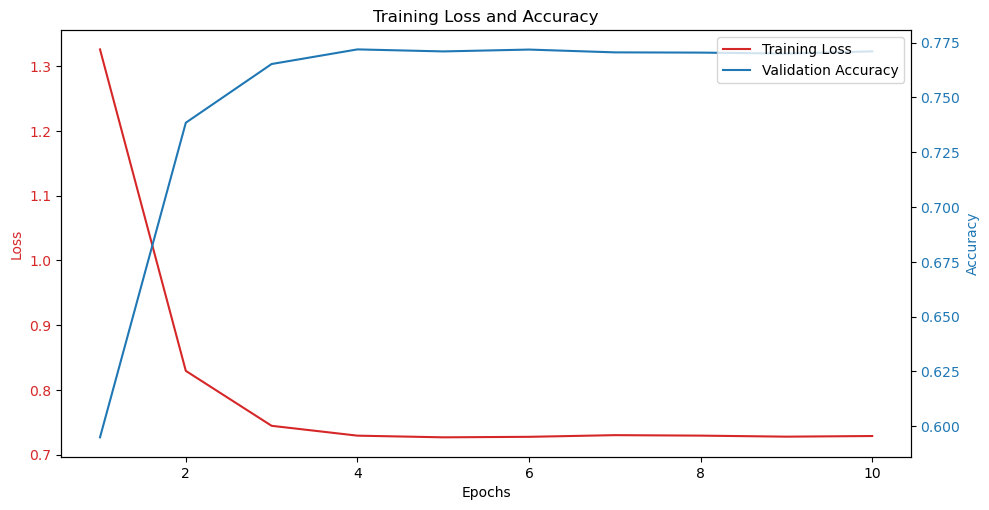

In [38]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) # define data loader, shuffle=True to randomise image order

trained_mlp, train_losses, train_accuracies = train_model(model=cnn, name='CNN', train_loader=train_loader, device=device) # train model

plot_metrics(train_losses=train_losses, accuracies=train_accuracies)

### Hyperparameter Tuning

In [39]:
initial_params = {
    'num_classes': 47,
    'channels': [32, 64],
    'kernel_sizes': [3, 3],
    'activation': nn.ReLU,
    'dropout_rate': 0.5,
    'use_dropout': False,
    'use_batchnorm': False
}

# Model creation for hyperparameter tuning with specified architecture
cnn_constructor = model_constructor_factory(model_class=FlexibleCNN, **initial_params)

hyp_optimiser = hyperparameter_optimisation(model_constructor=cnn_constructor, name = 'CNN', X=X_train, y=y_train, device=device)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        1.4287       0.6721        1.0582  0.0100  5.7489
      2        0.7390       0.7602        0.7533  0.0050  5.1914
      3        0.5995       0.7965        0.6306  0.0025  5.1532
      4        0.5133       0.8132        0.5654  0.0013  5.0518
      5        0.4558       0.8254        0.5259  0.0006  5.1393
      6        0.4190       0.8317        0.5085  0.0003  5.2748
      7        0.3970       0.8346        0.4983  0.0002  5.1531
      8        0.3842       0.8363        0.4929  0.0001  5.1495
      9        0.3769       0.8384        0.4909  0.0000  5.1150
     10        0.3729       0.8383        0.4902  0.0000  5.1675
Best: 0.836505616949597 using {'batch_size': 64, 'callbacks__lr_scheduler__gamma': 0.5, 'max_epochs': 10, 'module__activation': <class 'torch.nn.modules.act

### Train Optimised CNN model

Epoch 1, Loss: 1.598, Accuracy: 54.998%
Epoch 2, Loss: 0.736, Accuracy: 75.674%
Epoch 3, Loss: 0.600, Accuracy: 79.893%
Epoch 4, Loss: 0.527, Accuracy: 82.111%
Epoch 5, Loss: 0.480, Accuracy: 83.664%
Epoch 6, Loss: 0.458, Accuracy: 84.414%
Epoch 7, Loss: 0.441, Accuracy: 85.050%
Epoch 8, Loss: 0.434, Accuracy: 85.164%
Epoch 9, Loss: 0.429, Accuracy: 85.421%
Epoch 10, Loss: 0.424, Accuracy: 85.496%
Training time for CNN = 12.57 minutes.


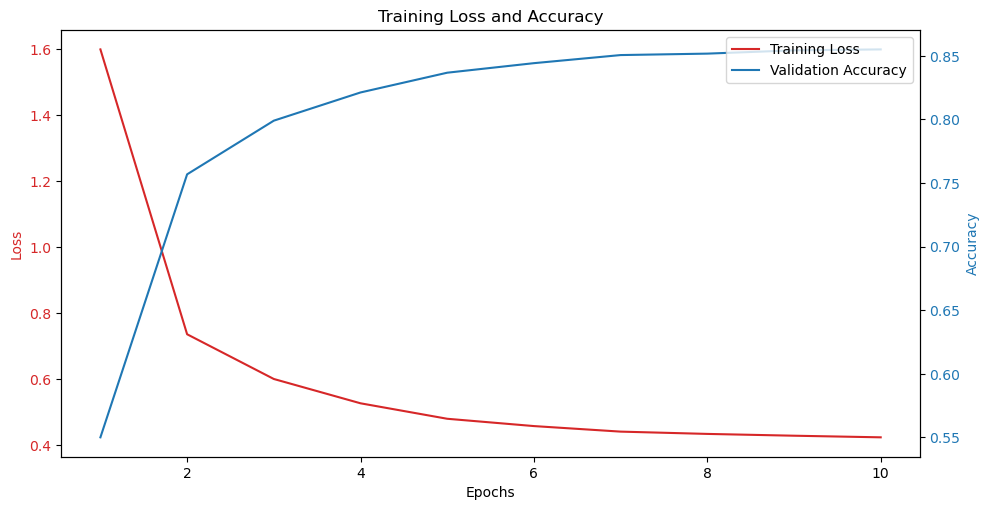

In [40]:
# Define optimised MLP model
cnn = FlexibleCNN(
    num_classes = 47, 
    channels=[64, 128],
    kernel_sizes=hyp_optimiser.best_params_['module__kernel_sizes'],
    activation=hyp_optimiser.best_params_['module__activation'],
    dropout_rate=hyp_optimiser.best_params_['module__dropout_rate'],
    use_dropout=hyp_optimiser.best_params_['module__use_dropout'],
    use_batchnorm=hyp_optimiser.best_params_['module__use_batchnorm']
).to(device)

train_loader = DataLoader(train_dataset, batch_size=hyp_optimiser.best_params_['batch_size'], shuffle=True) # define data loader, shuffle=True to randomise image order

trained_cnn, train_losses, train_accuracies = train_model(model=cnn, name='CNN', train_loader=train_loader, hyp_opt_params=hyp_optimiser, device=device) # train model

plot_metrics(train_losses=train_losses, accuracies=train_accuracies)

### Evaluate CNN model

Test Loss for CNN: 0.48
Accuracy for CNN = 84.084%
Precision for CNN = 0.842
Recall for CNN = 0.841
F1-score for CNN = 0.839


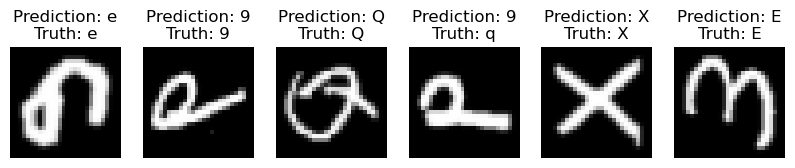

In [25]:
test_loader = DataLoader(test_dataset, batch_size=hyp_optimiser.best_params_['batch_size'], shuffle=False)

_, predictions, labels = evaluate(model=cnn, name='CNN', test_loader=test_loader, device=device)

visualise_predictions(test_loader, predictions)

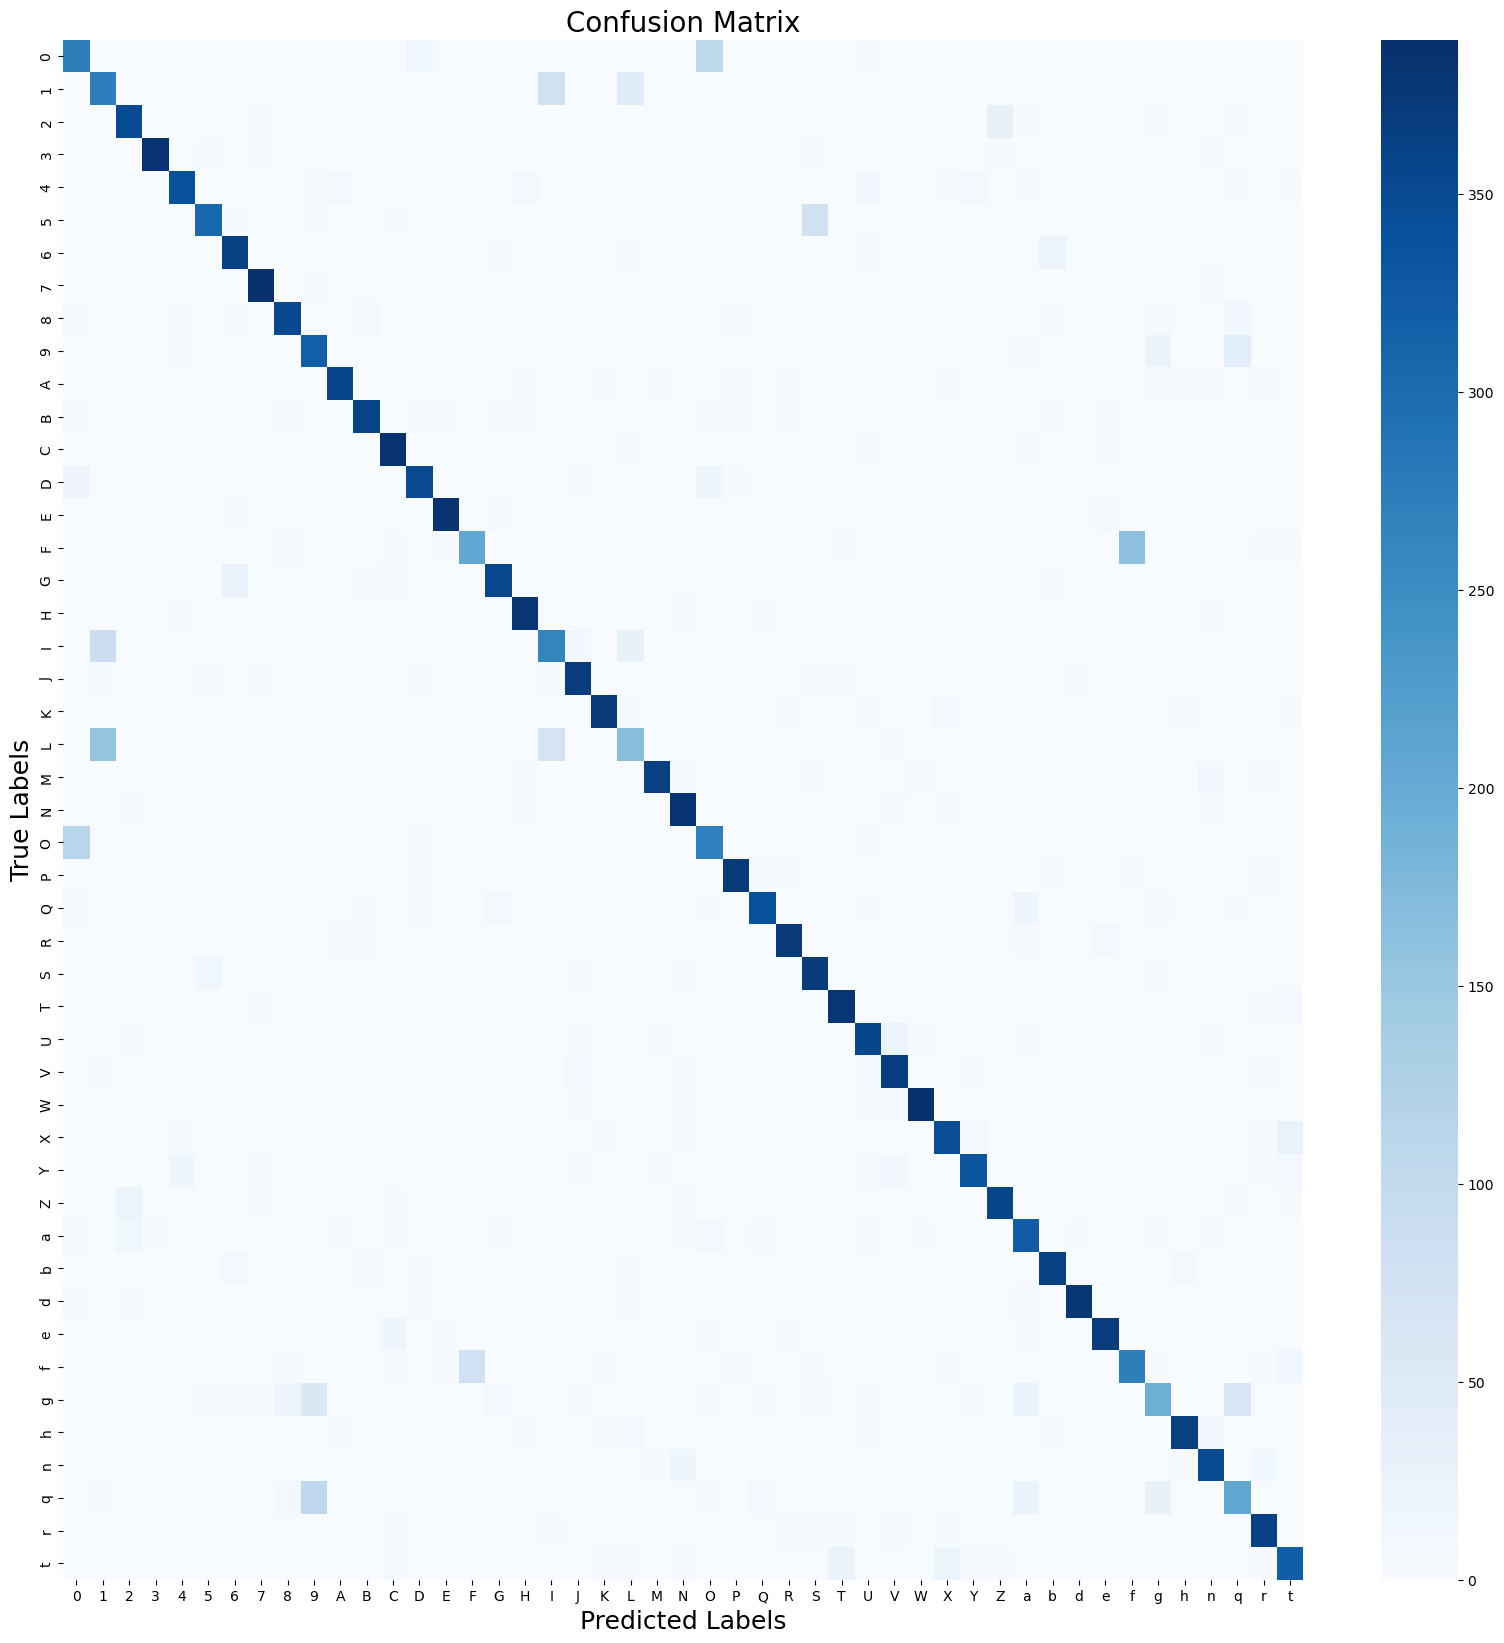

In [26]:
plot_confusion_matrix(labels=labels, predictions=predictions)